## 2.1 Getting your data + feature engineering

In [158]:
#import required libraries
import pandas as pd
import datetime
from datetime import datetime, date
from tqdm import tqdm as tq
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
import collections
import itertools
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
# !pip install bkmeans
from bkmeans import BKMeans

import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score as db
from sklearn import metrics

import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark import SQLContext
from pyspark.sql import SparkSession
import math

In [2]:
#import data and check them
data=pd.read_csv('bank_transactions.csv')
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


## Data cleaning

### Handle NaN

In [3]:
#drop NaN rows to avoid having customers without some information
data.dropna(inplace=True)

### Handle Customer DOB

In [4]:
#convert date of birth to datetime object
data['CustomerDOB']=pd.to_datetime(data.CustomerDOB, dayfirst=True)

In [5]:
#treat customers with date of birth greater than 2000
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [6]:
# Replace people with DOB as 1800 to mode DOB, since we suppose the dates are incorrect
mode_year=data[data.CustomerDOB.dt.year!=1800].CustomerDOB.mode()
data.loc[data.CustomerDOB.dt.year==1800,'CustomerDOB']=list(mode_year.values)[0]

### Handle Transaction Date

In [7]:
#convert transaction date column to datetime object
data.TransactionDate=pd.to_datetime(data.TransactionDate,dayfirst=True)

### Derive the Age of Customers

In [8]:
#compute the age for each customer ID to have a more relevant information frome tha date of birth
data["AGE"]=((datetime(2016,12,31)-data.CustomerDOB)/np.timedelta64(1, "Y")).astype(int)


In [9]:
data


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),AGE
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.0,22
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.0,59
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.0,20
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.0,43
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,181156,1762.5,28
...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-04-08,M,NEW DELHI,7635.19,2016-09-18,184824,799.0,26
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,183734,460.0,24
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,183313,770.0,27
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.0,38


### Transaction Time

In [10]:
#convert transaction time to datetime
data.TransactionTime=data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))
#this will create also a date that will be not correspondent to transaction date but since it will be the same for each customer it will not cause issues

In [11]:
#rename the column TransactionAmount(INR) with only TransactionAmount only for the sake of simplicity
data.rename({'TransactionAmount (INR)':'TransactionAmount'}, inplace=True, axis=1)

After this cleaning part we focus on the generation of the suggested features and 20+ more.
## 2. Feature engeenering

### a) Number of transactions

In [12]:
#groupby according to the customer ID and count the number of transactions for each ID
data['NumTransactions']=data.groupby('CustomerID')['CustomerID'].transform('count')

### b) Number of transactions with a balance bigger than 100 INR

In [13]:
#filter for transactions bigger than 100 USD, groupby according to the customer ID and count the number of transactions
data['NumTransactions_100'] = data[data['TransactionAmount'] > 100].groupby(['CustomerID'])['TransactionAmount'].transform('count')

In [14]:
#NaN values will appear when there aren't transactions bigger than 100 USD for certain customers, so we convert them to 0s
data.NumTransactions_100.fillna(0, inplace=True)

### c) Average amount of the transactions

In [15]:
#groupby for CustomerID and compute the mean among the transaction of that IDb
data['AvgTransactions'] = data.groupby(['CustomerID'])['TransactionAmount'].transform('mean')

### d) Average balance

In [16]:
#groupby as usual and compute the mean among the balances related to a certain customer ID
data['AvgBalance'] = data.groupby(['CustomerID'])['CustAccountBalance'].transform('mean')

### e) Average difference between the balance and the transaction amount for each customer, known as utilisation

In [17]:
#create a column with utilisation that then will be dropped
data['Utilisation']=data['CustAccountBalance'] - data['TransactionAmount']

In [18]:
#compute the mean of utilisation
data['AvgUtilisation'] = data.groupby(['CustomerID'])['Utilisation'].transform('mean')

In [19]:
#drop the utilisation column because is not needed anymore 
data.drop('Utilisation', axis=1, inplace=True)

### f) Most common gender of the customer

In [20]:
#compute the modal gender for each customer ID
data['Gender']=data.groupby(['CustomerID'])['CustGender'].transform(lambda x: pd.Series.mode(x).iloc[0])

### h) Most common location of the customer

In [21]:
#keep only the last word of the string in order to have uniform locations (the loss of information is minimal)
data['CustLocation']=data['CustLocation'].apply(lambda x: str(x).split()[-1])
#locations will end up in regions more than towns (for example we will have only Dehli and not New Delhi but the region will stay the same)

In [22]:
#compute the modal value location for each customer
data['Location']=data.groupby(['CustomerID'])['CustLocation'].transform(lambda x: pd.Series.mode(x).iloc[0])

In [23]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,AGE,NumTransactions,NumTransactions_100,AvgTransactions,AvgBalance,AvgUtilisation,Gender,Location
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,1900-01-01 14:32:07,25.0,22,1,0.0,25.0,17819.050,17794.050,F,JAMSHEDPUR
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,1900-01-01 14:18:58,27999.0,59,1,1.0,27999.0,2270.690,-25728.310,M,JHAJJAR
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,1900-01-01 14:27:12,459.0,20,1,1.0,459.0,17874.440,17415.440,F,MUMBAI
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,1900-01-01 14:27:14,2060.0,43,2,2.0,1469.2,434849.495,433380.295,F,MUMBAI
4,T5,C9031234,1988-03-24,F,MUMBAI,6714.43,2016-08-02,1900-01-01 18:11:56,1762.5,28,1,1.0,1762.5,6714.430,4951.930,F,MUMBAI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-04-08,M,DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,26,1,1.0,799.0,7635.190,6836.190,M,DELHI
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,24,1,1.0,460.0,27311.420,26851.420,M,NASHIK
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,27,2,2.0,489.0,112719.330,112230.330,M,HYDERABAD
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,38,1,1.0,1000.0,10117.870,9117.870,M,VISAKHAPATNAM


## 3. Generate at least 20 more features

## Features generated from transaction amount

### 1. Minimum value transaction for each ID
To get to know more customers it could be useful to know the extremes of their transactions, in addition to the mean.

In [24]:
#compute the minimum amount transaction for each ID
data['MinTransaction']=data.groupby(['CustomerID'])['TransactionAmount'].transform('min')

### 2. Maximum value transaction for each ID

In [25]:
#repeat for the maximum
data['MaxTransaction']=data.groupby(['CustomerID'])['TransactionAmount'].transform('max')

We see that in the case of only one transaction the minimum and the maximum coincide.

### 3. Median of the transaction amount
Since mean is influenced by extreme values it could be useful to observe the median of the transaction amount.

In [26]:
#compute the median of transaction amount for each ID
data['MdnTransaction']=data.groupby(['CustomerID'])['TransactionAmount'].transform('median')

### 4. Number of transactions greater than 10000 INR
This feature could help to understand if customers realize small or huge amount transactions to better understand the usage of their bank account. We observe that Approximate 2% of the people are involved in transactions with an amount greater than 10000 INR.

In [27]:
#compute the percentage of transaction greater than 10000 INR
data[data.TransactionAmount>10000].TransactionAmount.count()*100/len(data)

2.24804966139088

In [28]:
#filter the dataset for transactions greater than 10000 INR
data['NumTransactions_10000'] = data[data['TransactionAmount'] > 10000].groupby(['CustomerID'])['TransactionAmount'].transform('count')

In [29]:
#substitute NA values with 0s
data.NumTransactions_10000.fillna(0,inplace=True)
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,AGE,...,NumTransactions_100,AvgTransactions,AvgBalance,AvgUtilisation,Gender,Location,MinTransaction,MaxTransaction,MdnTransaction,NumTransactions_10000
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,1900-01-01 14:32:07,25.0,22,...,0.0,25.0,17819.050,17794.050,F,JAMSHEDPUR,25.0,25.0,25.0,0.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,1900-01-01 14:18:58,27999.0,59,...,1.0,27999.0,2270.690,-25728.310,M,JHAJJAR,27999.0,27999.0,27999.0,1.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,1900-01-01 14:27:12,459.0,20,...,1.0,459.0,17874.440,17415.440,F,MUMBAI,459.0,459.0,459.0,0.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,1900-01-01 14:27:14,2060.0,43,...,2.0,1469.2,434849.495,433380.295,F,MUMBAI,878.4,2060.0,1469.2,0.0
4,T5,C9031234,1988-03-24,F,MUMBAI,6714.43,2016-08-02,1900-01-01 18:11:56,1762.5,28,...,1.0,1762.5,6714.430,4951.930,F,MUMBAI,1762.5,1762.5,1762.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-04-08,M,DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,26,...,1.0,799.0,7635.190,6836.190,M,DELHI,799.0,799.0,799.0,0.0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,24,...,1.0,460.0,27311.420,26851.420,M,NASHIK,460.0,460.0,460.0,0.0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,27,...,2.0,489.0,112719.330,112230.330,M,HYDERABAD,208.0,770.0,489.0,0.0
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,38,...,1.0,1000.0,10117.870,9117.870,M,VISAKHAPATNAM,1000.0,1000.0,1000.0,0.0


## Getting Features from the Date of the Transactions:


### 5. The day of the month for transaction
### 6. The month of year in which the transaction was made
### 7. The weekday number on which the transaction was made


These features can help us understand the use of the bank account over time, extracting as much information as possible from the various time levels (eg. year, day of the week...).

In [30]:
#compute the transaction day, month and weekday from TransactionDate, previously parsed with datetime
data["Trans_day"]=data.TransactionDate.apply(lambda x:x.day)

data["Trans_month"]=data.TransactionDate.apply(lambda x:x.month)

data["Trans_weekday"]=data.TransactionDate.apply(lambda x:x.dayofweek)


### 8. Recency: Average of TransactionDates
This feature better indicates when account owners do their transactions during the year.

In [31]:
#compute the number of days from the starting of the year at which the transaction was made
def time_interval_transaction(series):
    days=[]
    for i in series:
  
        delta=i-datetime(2016,1,1,0,0,0)
        days.append(delta.days)
    return sum(days)/len(days)

In [32]:
#apply the function to the groupby object
data['Recency']= data.groupby(['CustomerID'])['TransactionDate'].transform(time_interval_transaction)

### 9. Number of transactions made in the first part of the year 

We want to observe the development of transactions per customer ID in the first part of the year by counting them and calculating their amount. Specularly, we also get information on the trend in the other half of the year.

In [33]:
#count transactions in the first part of the year for each customer
data['NumFirstHalfYear'] = data[data['TransactionDate'] < '2016-06-30'].groupby(['CustomerID'])['TransactionDate'].transform('count')

In [34]:
#substitute NaN values with with zeros
data.NumFirstHalfYear.fillna(0, inplace=True)

### 10. Amount of transactions in the first part of the year

In [35]:
#determine the amount of transactions fro each customer ID
data['AmountFirstHalf'] = data[data['TransactionDate'] < '2016-06-30'].groupby(['CustomerID'])['TransactionAmount'].transform('sum')

In [36]:
#substitute NaN values with with zeros
data.AmountFirstHalf.fillna(0, inplace=True)

## Features derived from customer Age
These features could help us to better understand the composition of the group of people (we suppose family in most of the cases), using the bank account associated with each ID.

### 11. Mean age for Customer ID


In [37]:
#compute the mean age
data['AvgAge'] = data.groupby(['CustomerID'])['AGE'].transform('mean').astype(int)

### 12. Minimum and maximum age
To detect extreme values and compare them.

In [38]:
#compute the minimum age value and cast it as int
data['MinAge'] = data.groupby(['CustomerID'])['AGE'].transform('min').astype(int)

In [39]:
#compute the maximum age and cast it at int
data['MaxAge']=data.groupby(['CustomerID'])['AGE'].transform('max').astype(int)

### 13. Number of transactions of people with more than 40 years
This feature allows us to understand the composition in terms of people over 40, i.e. adults who have access to the account.

In [40]:
#we filter the dataset for transactions belonging to customers of more than 40 years old and then count the number of transactions made
data['NumTransactions_40'] = data[data['AGE'] > 40].groupby(['CustomerID'])['TransactionAmount'].transform('count')

In [41]:
#subsitute NA with zeros
data['NumTransactions_40'].fillna(0,inplace=True)

## Features based on transaction time
To understand the trend in the use of the account for transactions at different times of the day.

### 14. Transactions which took place in the different parts of the day (Morning, Afternoon, Evening, Night).


In [42]:
#compute the function that encodes the different parts of the day
def transaction_time(series):
    if series.hour>=6 and series.hour<13: # Morning is encoded as 1
        return 1
    elif series.hour >= 13 and series.hour<=17: # Afternoon is encoded as 2
        return 2
    elif series.hour > 17 and series.hour <= 22: ## Evening is encoded as 3
        return 3
    elif series.hour > 22:  # Night is encoded as 4
        return 4
    elif series.hour < 6:   
        return 5

In [43]:
#apply it to TransactionTime
data['Transaction_part_day']=data.TransactionTime.apply(lambda x:transaction_time(x))

## Features based on Customer Account Balance
These features are useful as they allow us to understand the variability of the account balance of customers and thus understand their status. 

### 15. Median Balance
As usual since median is not eccessively influenced as mean by extreme values.

In [44]:
#groupby as usual and compute the median among the balances related to a certain customer ID
data['MdnBalance'] = data.groupby(['CustomerID'])['CustAccountBalance'].transform('median')

### 16. Balance greater than 100K INR

In [45]:
#filter the dataset for balances greater than 100K INR and then count
data['Balance_greater_100k']=data[data['CustAccountBalance']>100000].groupby(['CustomerID'])['CustAccountBalance'].transform('count')

In [46]:
#fill NA with zeros
data['Balance_greater_100k'].fillna(0,inplace=True)

### 17. Ratio of Transaction amount/ Balance in account
We create a new feature based for each customer, based on the average amount of transaction and average amount of balance.The aim of this feature to see the patterns in their transactions amount based on their account balance and to observe the management of the account in terms of expenditure in relation to how much is present in the account as balance.



In [47]:
#compute the ratio between the transaction amount and the balance present in the account
data['Tr_B_ratio'] = data.groupby(['CustomerID'])['TransactionAmount'].transform('mean')/ (data.groupby(['CustomerID'])['CustAccountBalance'].transform('mean')+1)

## Features based on Locations
Here we calculate for each customer how many location he had visited to make payments using his bank's services.This might be 
useful to differentiate between customers who are frequent travellers against the rest.

### 18. Numer of locations made in different places

In [48]:
#count the number of transactions made in different locations
data['Number_Locations']=data.groupby(['CustomerID'])['CustLocation'].transform('count')

### 19. Average Amount spent per location

In [49]:
#compute the average transaction amount spent for each location
data['Average_amount_location']=data.groupby('CustomerID')['TransactionAmount'].transform('mean')/data.groupby('CustomerID')['CustLocation'].transform('count')

In [50]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,AGE,...,AvgAge,MinAge,MaxAge,NumTransactions_40,Transaction_part_day,MdnBalance,Balance_greater_100k,Tr_B_ratio,Number_Locations,Average_amount_location
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,1900-01-01 14:32:07,25.0,22,...,22,22,22,0.0,2,17819.050,0.0,0.001403,1,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,1900-01-01 14:18:58,27999.0,59,...,59,59,59,1.0,2,2270.690,0.0,12.325185,1,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,1900-01-01 14:27:12,459.0,20,...,20,20,20,0.0,2,17874.440,0.0,0.025678,1,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,1900-01-01 14:27:14,2060.0,43,...,40,37,43,1.0,2,434849.495,1.0,0.003379,2,734.6
4,T5,C9031234,1988-03-24,F,MUMBAI,6714.43,2016-08-02,1900-01-01 18:11:56,1762.5,28,...,28,28,28,0.0,3,6714.430,0.0,0.262455,1,1762.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-04-08,M,DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,26,...,26,26,26,0.0,3,7635.190,0.0,0.104633,1,799.0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,24,...,24,24,24,0.0,3,27311.420,0.0,0.016842,1,460.0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,27,...,37,27,47,0.0,3,112719.330,1.0,0.004338,2,244.5
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,38,...,38,38,38,0.0,3,10117.870,0.0,0.098825,1,1000.0


To complete the picture on the features, we calculate this last mixed feature and in the process create the reduced dataset, removing the original features so that we have the final ones that can be subjected to the dimensional reduction analysis.

## Features based on transaction amount and time

As the 14th feature which could help to understand the transaction trend during the day for each costumer ID this one tries to get whether the amount of transactions varies with respect to different times of the day (eg. morning, afternoon).

### 20. Average amount of Transactions taking place in Morning and Afternoon



In [51]:
#define a function to identify transaction made in the first part of the day or the second
def trans_morn_afternoon(series):
    trans=0
    location=0

    for i in series.iterrows():
        if (transaction_time(i[1].TransactionTime)==1) or (transaction_time(i[1].TransactionTime)==2) :
            trans+=i[1].TransactionAmount
            location+=1
            
    #handle the situation in which no transaction took place neither in the morning nor in the afteroon       
    if location==0:
        return 0
    else:
       return trans/location

In [52]:
#apply the function to the groupby object without creating a new column otherwise we will obtain only NA values
x=data.groupby('CustomerID')['TransactionAmount','TransactionTime'].apply(trans_morn_afternoon)


Then we removed all the columns related to no needed features, dropping them to obtain a reduced dataset cointaining only the features of interest.

In [53]:
#remove original columns
data_reduced=data.drop(['TransactionID','CustomerDOB','CustGender','CustLocation','CustAccountBalance','MdnTransaction','AGE','TransactionDate','TransactionTime','TransactionAmount'],axis=1).copy()

In [54]:
dict2={}
for i in data_reduced.columns:
    if i!='CustomerID':
        dict2[i]=['mean']
dict2['Location']=['first']
dict2['Gender']=['first']

## Final Dataset

In [55]:
data_reduced=data_reduced.groupby('CustomerID').agg(dict2)
#remove row index to have as index the CustomerID
data_reduced.columns=data_reduced.columns.droplevel(1)
#add to the reduced dataset the column with the last feature
data_reduced['Trans_morn_afternoon']=x

In [59]:

data_reduced.head(5)

,NumTransactions,NumTransactions_100,AvgTransactions,AvgBalance,AvgUtilisation,Gender,Location,MinTransaction,MaxTransaction,NumTransactions_10000,...,MinAge,MaxAge,NumTransactions_40,Transaction_part_day,MdnBalance,Balance_greater_100k,Tr_B_ratio,Number_Locations,Average_amount_location,Trans_morn_afternoon
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2.0,2.0,2553.0,76340.635,73787.635,F,DELHI,356.0,4750.0,0.0,...,24.0,33.0,0.0,3.0,76340.635,0.5,0.033442,2.0,1276.50,4750.0
C1010012,1.0,1.0,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,0.0,...,22.0,22.0,0.0,3.0,24204.490,0.0,0.061928,1.0,1499.00,0.0
C1010014,2.0,2.0,727.5,100112.950,99385.450,F,MUMBAI,250.0,1205.0,0.0,...,24.0,32.0,0.0,2.5,100112.950,0.5,0.007267,2.0,363.75,1205.0
C1010018,1.0,0.0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,0.0,...,26.0,26.0,0.0,2.0,496.180,0.0,0.060340,1.0,30.00,30.0
C1010024,1.0,1.0,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,0.0,...,51.0,51.0,1.0,2.0,87058.650,0.0,0.057432,1.0,5000.00,5000.0


## Encoding Categorical Location:
>### We aim to use PCA for dimnesionality reduction and to use PCA we need to all the features in numerical format.
>### Hence we identify all the unique locations and assign as numerical identity to the locations in dataset.
>### Caveat: We are aware the numerical embedding of the categorical feature might not capture the total variations.
>### We tried to use MIXED Factor Analysis(Based on covariance between the features) for Feature reduction but we were facing memmory issue.

In [60]:
location_unique={} ## dictionary to store the unique location numerical embedding
counter=1 
## iterating over the unique locations
for i in tq(data_reduced.Location.unique()):
    location_unique[i]=counter
    counter+=1

100%|█████████████████████████████████████████████████████████████████████████| 3512/3512 [00:00<00:00, 1761798.31it/s]


In [61]:
data_reduced.Location=data_reduced.Location.apply(lambda row:location_unique[row])
data_reduced

,NumTransactions,NumTransactions_100,AvgTransactions,AvgBalance,AvgUtilisation,Gender,Location,MinTransaction,MaxTransaction,NumTransactions_10000,...,MinAge,MaxAge,NumTransactions_40,Transaction_part_day,MdnBalance,Balance_greater_100k,Tr_B_ratio,Number_Locations,Average_amount_location,Trans_morn_afternoon
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2.0,2.0,2553.0,76340.635,73787.635,F,1,356.0,4750.0,0.0,...,24.0,33.0,0.0,3.0,76340.635,0.5,0.033442,2.0,1276.50,4750.0
C1010012,1.0,1.0,1499.0,24204.490,22705.490,M,2,1499.0,1499.0,0.0,...,22.0,22.0,0.0,3.0,24204.490,0.0,0.061928,1.0,1499.00,0.0
C1010014,2.0,2.0,727.5,100112.950,99385.450,F,2,250.0,1205.0,0.0,...,24.0,32.0,0.0,2.5,100112.950,0.5,0.007267,2.0,363.75,1205.0
C1010018,1.0,0.0,30.0,496.180,466.180,F,3,30.0,30.0,0.0,...,26.0,26.0,0.0,2.0,496.180,0.0,0.060340,1.0,30.00,30.0
C1010024,1.0,1.0,5000.0,87058.650,82058.650,M,4,5000.0,5000.0,0.0,...,51.0,51.0,1.0,2.0,87058.650,0.0,0.057432,1.0,5000.00,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,1.0,1.0,691.0,133067.230,132376.230,M,82,691.0,691.0,0.0,...,26.0,26.0,0.0,5.0,133067.230,1.0,0.005193,1.0,691.00,0.0
C9099877,1.0,1.0,222.0,96063.460,95841.460,M,7,222.0,222.0,0.0,...,20.0,20.0,0.0,1.0,96063.460,0.0,0.002311,1.0,222.00,222.0
C9099919,1.0,1.0,126.0,5559.750,5433.750,M,234,126.0,126.0,0.0,...,23.0,23.0,0.0,1.0,5559.750,0.0,0.022659,1.0,126.00,126.0


## Encoding Categorical Gender:
> #### As mentioned in the previous section we use Numerical embedding to the gender. 
> #### Male:1,Female:2

In [62]:
data_reduced.Gender.value_counts()

M    619649
F    259708
T         1
Name: Gender, dtype: int64

In [63]:
## Since there is one gender as T and only in one row. We decide to replace as Female
data_reduced[data_reduced.Gender=='T'].Gender='F'

In [64]:
def gender_encoding(row):
    if row=='M':
        return 1
    else:
        return 2
    
data_reduced.Gender=data_reduced.Gender.apply(lambda row:gender_encoding(row))

## Going for Dimensionality Reduction:
> #### Now since we have all the features in numerical format we can use PCA for dimensionality reduction.
> #### Before using the PCA algorithm to reduce dimension(get more complex features which are basically linear combinations of orignal features), we standardise our data,mainly due to the fact:
>> #### The different features have different scale(alternatively their range values vary a lot),we transform our features ,so that no features enjoy bias in getting picked for the later stage(Clustering)

In [68]:
## Standardising the input dataset
data_reduced_stand=StandardScaler().fit_transform(data_reduced)

In [69]:
## Finding the First 10 principal Components from the Dataset
pca=PCA(n_components=10)
principalComponents=pca.fit_transform(data_reduced_stand)

#### We see that the First Seven Components explains atleast 70% of the variance in the Dataset


In [71]:
print(pca.explained_variance_ratio_[0:7],sum(pca.explained_variance_ratio_[0:7]))

[0.20202547 0.14503218 0.11372595 0.09969175 0.07407945 0.04646317
 0.04172036] 0.7227383149903014


In [72]:
##Transforming the dataset
data_pc=pd.DataFrame(data=principalComponents,columns=['Principal Component'+str(i) for i in range(1,11)])
data_pc

,Principal Component1,Principal Component2,Principal Component3,Principal Component4,Principal Component5,Principal Component6,Principal Component7,Principal Component8,Principal Component9,Principal Component10
0,0.398544,0.323271,0.083390,3.480227,0.408716,-0.836965,-0.766236,-0.328983,0.389733,-1.336398
1,-0.702845,1.530037,0.647448,-0.322622,-0.974967,0.206208,-0.751655,0.932207,-0.579763,1.154730
2,-0.215448,0.114620,0.139796,3.475156,-1.576433,1.199156,-1.009493,-0.511774,0.213391,-0.126973
3,-0.975488,0.971120,0.377065,-0.963902,1.904826,-0.349385,-0.694570,-1.087383,0.590831,-0.116282
4,2.453042,-3.456072,-2.463260,-1.129096,-0.897208,-0.425043,0.390938,-0.018543,-0.088684,0.083051
...,...,...,...,...,...,...,...,...,...,...
879353,-0.437009,0.422169,0.796887,-0.274363,-1.284345,0.974750,-1.955062,2.397444,-1.248755,0.500197
879354,-1.058193,1.612637,0.955173,-0.302466,1.916321,-0.279047,0.592043,-1.033048,0.307521,0.255048
879355,-0.971328,1.258301,0.515279,-0.401235,-0.937502,-0.532080,1.050404,-0.789576,0.080717,0.703526
879356,-1.226776,1.624232,0.862234,-1.091678,-0.348262,-1.699921,-0.601988,0.921210,-0.565346,1.347065


In [99]:
data_pc.iloc[:,0:7]

,Principal Component1,Principal Component2,Principal Component3,Principal Component4,Principal Component5,Principal Component6,Principal Component7
0,0.398544,0.323271,0.083390,3.480227,0.408716,-0.836965,-0.766236
1,-0.702845,1.530037,0.647448,-0.322622,-0.974967,0.206208,-0.751655
2,-0.215448,0.114620,0.139796,3.475156,-1.576433,1.199156,-1.009493
3,-0.975488,0.971120,0.377065,-0.963902,1.904826,-0.349385,-0.694570
4,2.453042,-3.456072,-2.463260,-1.129096,-0.897208,-0.425043,0.390938
...,...,...,...,...,...,...,...
879353,-0.437009,0.422169,0.796887,-0.274363,-1.284345,0.974750,-1.955062
879354,-1.058193,1.612637,0.955173,-0.302466,1.916321,-0.279047,0.592043
879355,-0.971328,1.258301,0.515279,-0.401235,-0.937502,-0.532080,1.050404
879356,-1.226776,1.624232,0.862234,-1.091678,-0.348262,-1.699921,-0.601988


### Finding the optimal number of clusters
> First using the Elbow method and taking leverage of yellow brick library for visualisation of Elbow method results

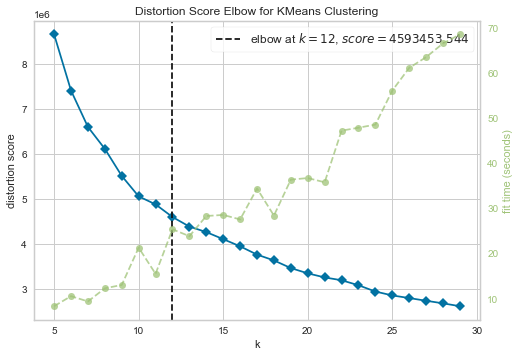

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [101]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,30))

visualizer.fit(data_pc.iloc[:,0:7])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


> Second Method is based using Calinski-Harabasz score to find the optimal Clusters.

> We iterate over the possible ranges of K from 5 to 30 and use scikit-learn kmeans to evaluate the different clusters formed for different K.

>The Calinski-Harabasz is the ratio of the sum of *between-clusters dispersion* and of *inter clusters* dispersion for all the clusters computed for a given value of K.

In [103]:
score=[]
for k in tq(range(5, 30)):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(data_pc.iloc[:,0:7])
    labels = kmeans_model.labels_
    sc=metrics.calinski_harabasz_score(data_pc.iloc[:,0:7], labels)
    score.append(sc)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [12:51<00:00, 30.86s/it]


<AxesSubplot:>

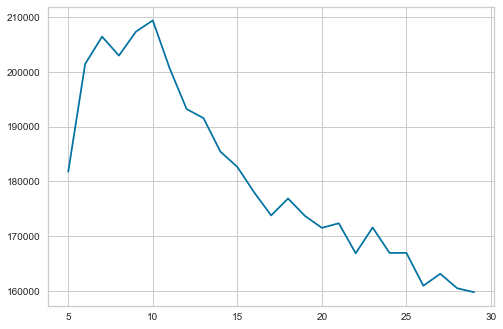

In [105]:
import seaborn as sns
sns.lineplot(x=range(5, 30),y=score)

### Choosing between Elbow method and Calinski-Harabasz score:

> Elbow method faces disadvantages as the main idea behind Elbow methods is to find the number of clusters which minimizes the cost function of the Kmeans i.e the sum of the distance square from it's respective centroid. We then iterate over the different values of K and calculate the cost function value.

>> Further, we look for that part of the curve where the decrease in the cost function is quite small(rate of change) and assume the first value of K where this behaviour is seen. 

>Elbow method is not very precise and reliable in the sense it might overestimate the number of clusters required as increasing the number of clusters our cost function always decreases.

>Hence we should use some other metrics which uses other characteristics of the cluster's (for eg. distance between different clusters)

>Since Calinski-Harabasz score accounts both inter and intra clusters dispersion,we feel that using optimal K suggestion from Calinski-Harabasz score would be more reliable.

## Implementing K-means using Map reduce

In [108]:
##Setting up pyspark
conf = pyspark.SparkConf()
spark=SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext
## Reading the stored Principal Components for the dataset.
df=spark.read.csv('Data_PC.csv')

In [109]:
## Retrieving the data from the dataframe
points=df.collect()

In [114]:
##Retrieving the data of first seven principal components for each customer(these seven principal components explain about 
##72.3% of the variance)
coord=[]
###iterating over the points data
for i,row in enumerate(points):
    if i!=0:
        coord.append(tuple([eval(row[j]) for j in range(1,8)])) ##Getting the first seven principal components 
##Converting list to RDD object     
coord=sc.parallelize(coord)

In [120]:
coord.count()

879358

In [115]:
## Random Intialisation of Centroids for Kmeans
def intial_centroid(coord,k):
    
    """"
    input:coord:RDD object: It contains the the coordinates mapped on the space defined by the seven principal components
          k:Integer:The number of centroids that need to be intialise
    objective:It performs the random intialisation of the required number of centroids.
    returns:centroids: List: Containig the k centroids.
    
    """""
    centroids=[]
    counter=1
    
    ## Random sample k numbers between 1 and total numer of samples(customers) present in coord
    index=random.sample(range(1,coord.count()),k)

    for i in range(k):
        
        ## Based on the randomly sample number retrieve the coordinates for those randomly sampled customers
        centroids.append(tuple([coord.take(index[i])[index[i]-1],counter]))
        
        counter +=1
    return centroids
        
        


In [116]:
## Distance between two points
def distance(c1,c2):
    """"
    input:c1:A tuple: Containing the coordinates information of point A
          c2:A tuple: Containing the coordinates information of point B
    objective:It computes the distance between two points
    returns:float: distance between two points
    
    """""
    dist=0
    for i in range(len(c1)):
        dist+=(c1[i]-c2[i])**2
    return math.sqrt(dist)


In [117]:
## Computing the closest Centroid:
def best_centroid(centroids,point):
    """"
    input:centroid:A tuple: ((x1,x2,x3...),1) This contains the coordinates of the centroids and it's index
          c2:A tuple: Containing the coordinates information of point 
    objective:It computes the index of the centroid which is closest to the point.
    returns:Integer:index of centroid.
    
    """""
    
    dist=100000000

    best_centroid=0
    
    for centroid in centroids:
        dist_cent=distance(centroid[0],point) ## Calculating distance between point and centroid
        ## if the distance is smaller than the minimum distance calulcated till now,update the smallest distance and 
        ##index of the centroid it's closest two
        if dist_cent<dist: 
            dist=dist_cent
            best_centroid=centroid[1] ## The index of the closest centroid

    return best_centroid

In [111]:
## Adding two points(used in Reduced Step)
def sum_points_centroid(p1,p2): ### ###[,1]
    """"
    input:p1:list: [(x1,x2,x3...),s] This contains the coordinates of the point(which is a sum of coordinates of points 
                        belonging the same cluster followed by the number of points that have been used till now 
                        to get the coordinates
          p2:list: [(y1,y2,y3...),t] This contains the coordinates of the point(which is a sum of coordinates of points 
                        belonging the same cluster followed by the number of points that have been used till now 
                        to get the coordinates
    objective:The main objective of the fuction is to add two points information which would we used to compute the final centroid.
            So we need to keep track of the sum of coordinates and total number of points belonging in the cluster
    returns:A list:[(x1+y1,x2+y2,x3+y3,...),s+t]
    
    """""
    
    sum_coord=tuple([sum(x) for x in zip(p1[0],p2[0])])  ###(x1+y1,x2+y2,x3+y3,...)
    sum_points=p1[1]+p2[1]  ## s+t
    return [sum_coord,sum_points] ###

In [112]:
## This would be used for sorting a list of computed new_centroids based on the index of the cluster
def sort_func(x):
    return x[1]

In [118]:
## We first convert every point(customer) into [(x1,x2,x3...x7),1]. This is done with the motivation that during the reduce step
## we are able to keep track of number of points belonging the cluster
points_key=coord.map(lambda x:[x,1])
## Since these points would be used every iteration so we push the data into cache which helps in faster operations(they don't
## collected every map or reduce step is called)
points_key.cache()


PythonRDD[14] at RDD at PythonRDD.scala:53

In [121]:
### defining the threshold between updated and old centroids. If the distance between them is less than 0.001 we assume that 
### centorids have converged
threshold=0.001

### Number of Maximum iteration to run K-means
max_iter=100

##intialising the centroids
cent=intial_centroid(coord,10)


for i in tq(range(max_iter)):
    ## In map step we map all the points to it's closest centroid
    map_points=points_key.keyBy(lambda x:best_centroid(cent,x[0]))
    
    ## In reduced step we sum all the points information belong to specific clusters.So in the end we sum all coordinates and
    ## get the total number of points used to get the sum
    reduced_points=map_points.reduceByKey(lambda a,b:sum_points_centroid(a,b))
    
    ## retrieve the points from reduced step
    reduced_points=reduced_points.collect()
    
    ### Getting the new centroid
    new_cent=[]
    for row in reduced_points:
        index=row[0]
        ##dividing the sum of coordinates with total number of points to get the updated coordinates of new centroid
        new_index_coord=tuple(map(lambda x:x/row[1][1],row[1][0]))
        new_cent.append(tuple([new_index_coord,index]))
    
    ###sorting the updates centroid based on the index of the centroid
    new_cent.sort(key=myfunc)

    ## Checking for convergence
    convergedCentroids = 0
    
    for index, centroid in enumerate(cent):
            dist = distance(centroid[0], new_cent[index][0])

            if dist < threshold:
                    convergedCentroids+=1
    
    cent = new_cent
    
    ## If 90% of the centroids have converged (the distance between old and updated centroid is less than threshold),we assume
    ## k-means have converged.
    percentage = len(cent) * 90 / 100

    if convergedCentroids > percentage:
            print("Centroids converged")
            break
    


[544243, 206136, 113907, 86108, 860835, 505467, 442881, 466936, 389235, 474420]


 50%|████████████████████████████████████████▌                                        | 50/100 [15:13<15:13, 18.27s/it]

Centroids converged


In [122]:
## Getting the centroid index for each of the customers based on the centroid obtained from k-means.
data_pc['Cent_kmeans']=data_pc.apply(lambda x: best_centroid(cent,x.values),axis=1)


### Visualising the clusters from k-means

<IPython.core.display.Javascript object>


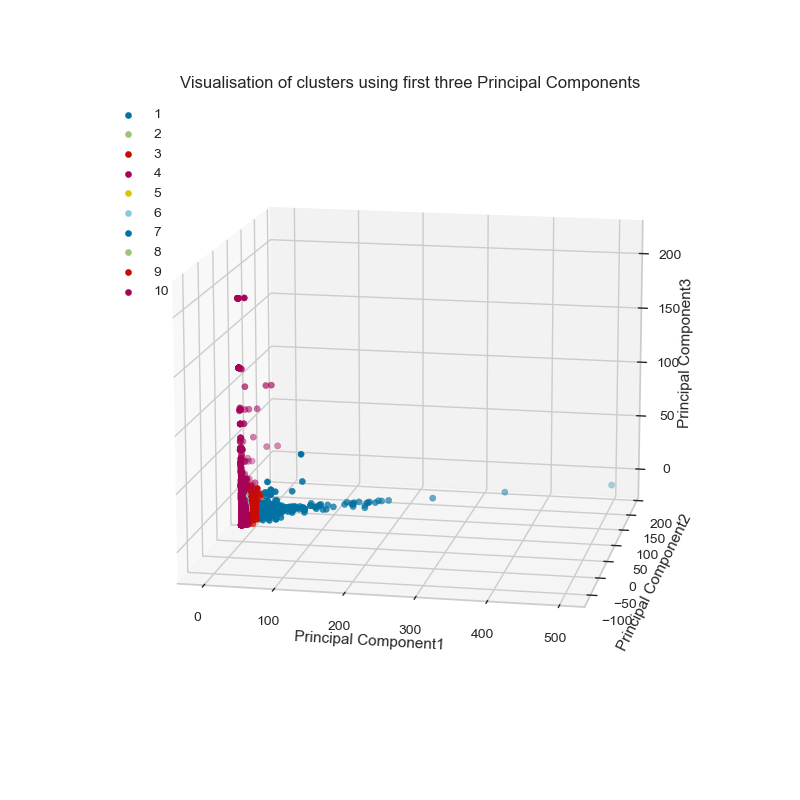

In [131]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(projection='3d')

#1 - Looping Through Group Information
for grp_name, grp_idx in data_pc.groupby('Cent_kmeans').groups.items():
    x = data_pc.loc[grp_idx, 'Principal Component1']
    y = data_pc.loc[grp_idx, 'Principal Component2']
    z = data_pc.loc[grp_idx, 'Principal Component3']
    axes.scatter(x, y, z, label=grp_name, s=20)
#2 - Adding The Legend To The Axes Object
axes.legend(loc='upper left')
axes.set_title("Visualisation of clusters using first three Principal Components")
axes.set_xlabel('Principal Component1')
axes.set_ylabel('Principal Component2')
axes.set_zlabel('Principal Component3')
plt.show()

### Now we go for K-means ++ 

In [132]:
## Performing k-means++ using scikit-learn methods.
kmeans = KMeans(n_clusters=10, random_state=0,init='k-means++').fit(data_pc.iloc[:,0:7])

In [133]:
cent_2=kmeans.cluster_centers_ ### Centroids from kmeans++

## Adding the index of the centroid for all the obtained centroids 
cent_plus=[]
for i in range(len(cent_2)):
    cent_plus.append((tuple(cent_2[i]),i+1))

data_pc['Cent_plus']=data_pc.apply(lambda x: best_centroid(cent_plus,x.values[0:7]),axis=1)

### Visualising the clusters from K-means ++

<IPython.core.display.Javascript object>


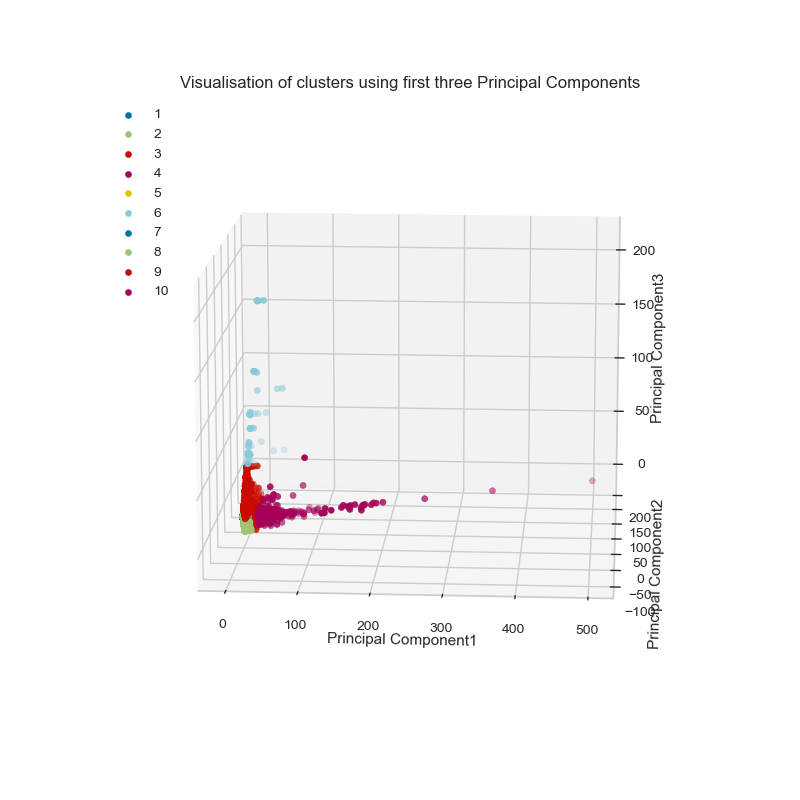

In [136]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(projection='3d')

#1 - Looping Through Group Information
for grp_name, grp_idx in data_pc.groupby('Cent_plus').groups.items():
    x = data_pc.loc[grp_idx, 'Principal Component1']
    y = data_pc.loc[grp_idx, 'Principal Component2']
    z = data_pc.loc[grp_idx, 'Principal Component3']
    axes.scatter(x, y, z, label=grp_name, s=20)
#2 - Adding The Legend To The Axes Object
axes.legend(loc='upper left')
axes.set_title("Visualisation of clusters using first three Principal Components")
axes.set_xlabel('Principal Component1')
axes.set_ylabel('Principal Component2')
axes.set_zlabel('Principal Component3')
plt.show()

### Comparing results between K-means and K-means ++ using David Bouldin Score

In [151]:
## For k-means
metrics.davies_bouldin_score(data_pc.values[:,0:7],labels=data_pc['Cent_kmeans'])

1.6750654806510936

In [153]:
## For k-means++
metrics.davies_bouldin_score(data_pc.values[:,0:7],labels=data_pc['Cent_plus'])

0.8820889631569759

> We notice that we get lower David Bouldin Score for K-means++ than K-means.

> David Bouldin Score in broad terms is the ratio of how spread the clusters(cluster scatter) and the different cluster's seperation.So lower David Bouldin Score conveys better seperation between the Cluster.

> Hence based on DB score we infer that cluster obtained are more optimal than k-means.

In [127]:
df_reduced_stand=pd.DataFrame(data=data_reduced_stand,columns=data_reduced.columns)
df_reduced_stand['Cent_kmeans']=data_pc['Cent_kmeans']
##Storing the results obtained from K-means that would be used in section 2.4
df_reduced_stand.to_csv('Dataset_centroid_standard.csv')

## Bonus Part

> Here we have attempted to use one-more clustering algorithm-Bisecting K-means

In [162]:
Bkmeans = BKMeans(n_clusters=10, random_state=0,init='k-means++').fit(data_pc.iloc[:,0:7])

In [164]:
cent_3=kmeans.cluster_centers_ ### Centroids from kmeans++

## Adding the index of the centroid for all the obtained centroids 
cent_bk=[]
for i in range(len(cent_2)):
    cent_bk.append((tuple(cent_3[i]),i+1))

data_pc['Cent_BK']=data_pc.apply(lambda x: best_centroid(cent_bk,x.values[0:7]),axis=1)

In [165]:
## For k-means++
metrics.davies_bouldin_score(data_pc.values[:,0:7],labels=data_pc['Cent_BK'])

0.891399219375456

Comparison:
        
> K-means: 1.6750654806510936

> K-means++: 0.8820889631569759

> Bisecting K-means: 0.891399219375456

> For the three clustering algorithm we see that K-means++ has the least David-Bouldin Score.Since all these three are based on minimising the same cost function,they have slight variation in implementation.

>K-means++ does not use random intialisation instead the points are picked based on probability(proportional to the distance from the centroid). First centroid is randomly picked after which all the other points in the space have probability attached to it for being picked up as an centroid.

>Bisecting-Kmeans: It's a modified version of K-means which is an overlap of partition and hierarchical based clustering. It start's with considering the whole data as one cluster and then bisects the data into two parts resulting in two centroids.This process is continued until K clusters have been formed. This is computational more effective as compared to k-means as each stage it does not consider all the points for calculation of the centroid.

>Based,on David Bouldin score we infer that K-means++ is a better performing algorithm due to the fact of choosing intial centroids in a reliable way.